# Test on the loss function scaling in deep and shallow circuits

In [58]:
import numpy as np
import pennylane as qml

In [60]:
N = 2 # number of qubits
L = 1 # number of layers

# Define a quantum device with 2 qubits
dev = qml.device("default.mixed", wires=N)
wires = np.arange(N)

In [29]:
# Define a single layer of the circuit
def layer(params):
    
    for wire,param in zip(wires,params):
        qml.RX(param, wires=wire)

    for i in range(len(wires) - 1):
        qml.CNOT(wires=[wires[i], wires[i + 1]])

    # Add a depolarizing channel to each qubit
    for wire in wires:
        qml.DepolarizingChannel(0.1, wires=wire)
   

# Define a quantum node (QNode)
@qml.qnode(dev)
def circuit(params,layers=2):

    # Add multiple layers
    for i in range(layers):  # Example: 3 layers
        layer(params[i,:]) 

    # Measure the expectation value of PauliZ on both qubits
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

In [30]:
# Example parameters
params = np.random.normal(size=(L,N))

# Execute the circuit
result = circuit(params,layers=L)
print("Circuit output:", result)

drawer = qml.draw(circuit, show_all_wires=True, wire_order=[0,1], decimals=1)
print(drawer(params,L))

Circuit output: (np.float64(-0.03792561519550364), np.float64(-0.03055504365166639))
0: ──RX(1.6)──╭●──DepolarizingChannel(0.1)───────────────────────────┤  <Z>
1: ──RX(0.6)──╰X─╭●─────────────────────────DepolarizingChannel(0.1)─┤  <Z>
2: ──RX(-1.7)────╰X─────────────────────────DepolarizingChannel(0.1)─┤     


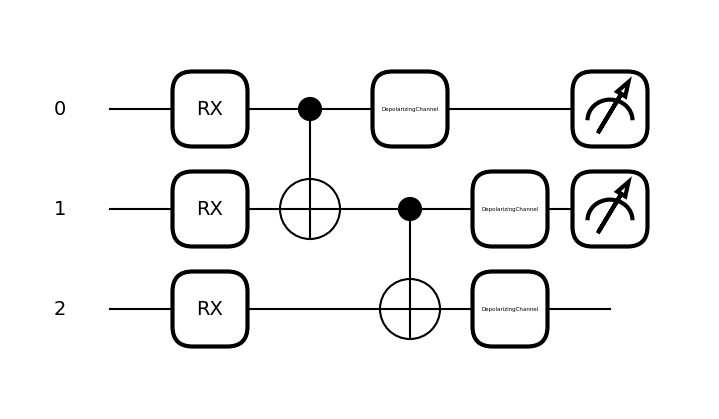

In [109]:
fig, ax = qml.draw_mpl(circuit,expansion_strategy="device",style="black_white")(params,layers=L)

In [64]:
N=3

In [65]:
h = 9/N
scale = 2**(N/2)

# Build the Hamiltonian: sum Z_k ⊗ Z_{k+1}
coeffs = [h * scale for _ in range(N - 1)]
ops = [qml.PauliZ(k) @ qml.PauliZ(k + 1) for k in range(N - 1)]
H = qml.Hamiltonian(coeffs, ops)


def maximally_entangled_state(N):
    ghz_state = np.zeros(2**N, dtype=complex)
    ghz_state[0] = 1 / np.sqrt(2)         # |000⟩
    ghz_state[-1] = 1 / np.sqrt(2)        # |1⟩
    qml.StatePrep(ghz_state, wires=range(N))

def layer(params, N, L):
    """Apply RX rotations to all qubits."""
    for i in range(N):
        qml.RX(params[i], wires=i)
        
        if i < N - 1:
            qml.CNOT(wires=[i, i + 1])

def custom_layer(params, apply_entangled, N, L):
    """Apply one full layer of RX + (CNOT or Entangled state)."""
    
    if apply_entangled:
        maximally_entangled_state(N)
    else:
        layer(params, N, L)

In [74]:
import torch as th

N = 5

h = 9/N
scale = 2**(N/2)

# Build the Hamiltonian: sum Z_k ⊗ Z_{k+1}
coeffs = [h * scale for _ in range(N - 1)]
ops = [qml.PauliZ(k) @ qml.PauliZ(k + 1) for k in range(N - 1)]
H = qml.Hamiltonian(coeffs, ops)

def generate_H(N):
    h = 9/N
    scale = 2**(N/2)

    Z = th.tensor([[1, 0], [0, -1]], dtype=th.complex128)

    ZZ = th.kron(Z, Z)

    H = th.zeros(2**N, 2**N, dtype=th.complex128)

    for i in range(N-1):
        H += th.kron( th.eye(2**i), th.kron(ZZ, th.eye(2**(N-i-2))) )

    return h*scale*H

np.sum(H.matrix() - generate_H(N).numpy())

np.complex128(0j)

In [27]:
def calc_variance(p,N,L):
    state = 0
    n_sim = 1

    for _ in range(n_sim):
        params = np.random.uniform(0, np.pi, size=(L, N))

        # Sample whether to entangle or use CNOT at each layer
        entangle_flags = np.random.rand(L) < p  # Boolean array

        dev = qml.device("default.qubit", wires=N)

        @qml.qnode(dev)
        def circuit(params, entangle_flags):
            """Build a circuit using repeated custom layers."""
            for i, apply_entangled in enumerate(entangle_flags):
                custom_layer(params[i], apply_entangled, N, L)
            return qml.expval(H)

        # Run the circuit
        state += circuit(params, entangle_flags)
    
    return state/n_sim


p = 1  # Probability to apply maximally entangled state
N = 4
L = 2

print(calc_variance(1,N,L))


13.499999999999993


In [75]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 3
dev = qml.device("default.mixed", wires=n_qubits)

# State 1: Rotation + CNOT
@qml.qnode(dev)
def evolved_state():
    qml.RY(np.pi / 4, wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.density_matrix(wires=range(n_qubits))

# State 2: GHZ
@qml.qnode(dev)
def ghz_state():
    ghz = np.zeros(2**n_qubits, dtype=complex)
    ghz[0] = 1/np.sqrt(2)
    ghz[-1] = 1/np.sqrt(2)
    qml.StatePrep(ghz, wires=range(n_qubits))
    return qml.density_matrix(wires=range(n_qubits))

def probabilistic_state(p=0.3, shots=1000):
    dm_sum = np.zeros((2**n_qubits, 2**n_qubits), dtype=complex)

    for _ in range(shots):
        if np.random.rand() < p:
            dm = ghz_state()
        else:
            dm = evolved_state()
        dm_sum += dm

    return dm_sum / shots

rho = probabilistic_state(p=0.3, shots=1000)
print(np.round(rho, 3))


[[0.744+0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.244+0.j
  0.155+0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.   +0.j]
 [0.244+0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.101+0.j
  0.   +0.j]
 [0.155+0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
  0.155+0.j]]
